<a href="https://colab.research.google.com/github/vermakun/UMD-SS21-ECE-5831-ECU-Fingerprinting/blob/main/ecu_fingerprint_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In-Vehicle Security using Pattern Recognition Techniques
---
*ECE 5831 - 08/17/2021 - Kunaal Verma*

The goal of this project is to train a machine learning model to recognize unique signatures of each ECU in order to identify when intrusive messages are being fed to the network.

The dataset for this project consists of several time-series recordings of clock pulses produced by several ECUs on an in-vehicle CAN High network.

The test network has 8 trusted ECUs, with 30 records of 600 samples of the clock signal for each ECU.


# I. Initialization

In [1]:
### I. Initialization ###
print('--- Intialize ---')

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sn
import sklearn.metrics as sm

from google.colab import drive
drive.mount('/content/drive')

--- Intialize ---
Mounted at /content/drive


# II. File Pre-conditioning


In [2]:
### II. File Pre-conditioning ###
print('\n--- Pre-condition Files ---\n')

# Dataset path
datapath = 'drive/MyDrive/School/UMich Dearborn/SS21/ECE 5831/Project/Dataset'
# datapath = './Dataset'

print('Path to Dataset:')
print(datapath)

# List of files in directory, append to list recursively
file_list = []
for path, folders, files in os.walk(datapath):
    for file in files:
        file_list.append(os.path.join(path, file))

# Sort file list by record number, but use a copy that contains leading zeros
file_list0 = []
for filename in file_list:
    m = re.search('_[0-9]\.', filename)
    if m:
      found = m.group(0)
      filename = re.sub('_[0-9]\.', found[0] + '0' + found[1:-1] + '.', filename)
    file_list0.append(filename)

file_list1 = dict(zip(file_list0,file_list))
file_list2 = dict(sorted(file_list1.items(), key = lambda x:x[0]))

# Produce sorted file lists
file_list  = list(file_list2.values())  # Original list, properly sorted
file_list0 = list(file_list2.keys())    # Modified list with leading zeros, sorted

print('\nAbsolute Paths to Records (Subset):')
for filename in file_list[0:10]:
  print(filename)


--- Pre-condition Files ---

Path to Dataset:
drive/MyDrive/School/UMich Dearborn/SS21/ECE 5831/Project/Dataset

Absolute Paths to Records (Subset):
drive/MyDrive/School/UMich Dearborn/SS21/ECE 5831/Project/Dataset/CAN1_2m_Thin_uns1/CAN1Aauns1_1.csv
drive/MyDrive/School/UMich Dearborn/SS21/ECE 5831/Project/Dataset/CAN1_2m_Thin_uns1/CAN1Aauns1_2.csv
drive/MyDrive/School/UMich Dearborn/SS21/ECE 5831/Project/Dataset/CAN1_2m_Thin_uns1/CAN1Aauns1_3.csv
drive/MyDrive/School/UMich Dearborn/SS21/ECE 5831/Project/Dataset/CAN1_2m_Thin_uns1/CAN1Aauns1_4.csv
drive/MyDrive/School/UMich Dearborn/SS21/ECE 5831/Project/Dataset/CAN1_2m_Thin_uns1/CAN1Aauns1_5.csv
drive/MyDrive/School/UMich Dearborn/SS21/ECE 5831/Project/Dataset/CAN1_2m_Thin_uns1/CAN1Aauns1_6.csv
drive/MyDrive/School/UMich Dearborn/SS21/ECE 5831/Project/Dataset/CAN1_2m_Thin_uns1/CAN1Aauns1_7.csv
drive/MyDrive/School/UMich Dearborn/SS21/ECE 5831/Project/Dataset/CAN1_2m_Thin_uns1/CAN1Aauns1_8.csv
drive/MyDrive/School/UMich Dearborn/SS21/E

# III. Feature Extraction



In [10]:
### III. Feature Extraction ###
print('\n--- Extract Features ---\n')

!cp '/content/drive/MyDrive/School/UMich Dearborn/SS21/ECE 5831/Project/github/ecu_fingerprint_lib.py' .
from ecu_fingerprint_lib import Record

pkl_path = './ecu_fingerprint.pkl'

if os.path.exists(pkl_path):

  df = pd.read_pickle(pkl_path)
  
else:

  # Dict instantiation
  d = {}

  # Iteratively build data dictionary
  for i in np.arange(len(file_list0)):

    filepath  = file_list[i]
    filepath0 = file_list0[i]

    print(filepath)

    # Extract folder name of current record
    folder = os.path.basename(os.path.dirname(filepath0))
    filename = os.path.basename(filepath0)

    # Extract record identifiers
    id, pl, pm, did = folder.split('_')
    filename = re.split(r'_|\.',filename)

    # Open File
    with open(filepath) as file_name:
      array = np.loadtxt(file_name, delimiter=",")
    
    # Extract Features
    r = Record(array)
    
    # Add Features and File Attributes to Dict
    if i == 0:
      #   File Metadata
      d['Filepath']   = []
      d['CAN_Id']     = []
      d['CAN_PhyLen'] = []
      d['CAN_PhyMat'] = []
      d['CAN_RecId']  = []
      #   Feature Data
      for feature_name in r.headers:
        d[feature_name]   = []

    # Build data table
    for k in np.arange(r.total_rec):
      for j in np.arange(len(r.headers)):
        d[r.headers[j]].append(r.features[j][k])
      d['Filepath'].append(filepath)
      d['CAN_Id'].append(id)
      d['CAN_PhyLen'].append(pl)
      d['CAN_PhyMat'].append(pm)
      d['CAN_RecId'].append(filename[-2])

  df = pd.DataFrame.from_dict(d)
  df.to_pickle(pkl_path)

print('\nDataFrame Object:\n')
print(df.info())


--- Extract Features ---


DataFrame Object:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Filepath                943 non-null    object 
 1   CAN_Id                  943 non-null    object 
 2   CAN_PhyLen              943 non-null    object 
 3   CAN_PhyMat              943 non-null    object 
 4   CAN_RecId               943 non-null    object 
 5   Dom_Peak_Time           943 non-null    float64
 6   Dom_Steady_State_Value  943 non-null    float64
 7   Dom_Steady_State_Error  943 non-null    float64
 8   Dom_Percent_Overshoot   943 non-null    float64
 9   Dom_Settling_Time       943 non-null    float64
 10  Dom_Rise_Time           943 non-null    float64
 11  Dom_Delay_Time          943 non-null    float64
 12  Dom_Spectral_Bin_0      943 non-null    float64
 13  Dom_Spectral_Bin_1      943 non-null    float64


# IV. Prepare Training and Test Datasets

In [ ]:
### IV. Prepare Traininf and Test Datasets ###
print('\n--- Training and Test Datasets ---\n')

# Attribute and Label Datasets

## Full, Dom, Rec
X = df.iloc[:,5:]     # Full feature set                                        0.0%

y = df.iloc[:,1]

# Change Labels from Categorical to Numerical values

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
Y = le.fit_transform(y)

# Train-Test Split (70/30)

from sklearn.model_selection import train_test_split
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=4)    # Apples to Apples Debugging
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

# Feature Scaling

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

print('Training Input:\n')
print('    %s: %s' %(X_train.dtype, X_train.shape))
print('\nTraining Output:\n')
print('    %s: %s' %(Y_train.dtype, Y_train.shape))
print('\nTest Input:\n')
print('    %s: %s' %(X_test.dtype, X_test.shape))
print('\nTest Output:\n')
print('    %s: %s' %(Y_test.dtype, Y_test.shape))


--- Training and Test Datasets ---

Training Input:

    float64: (660, 35)

Training Output:

    int64: (660,)

Test Input:

    float64: (283, 35)

Test Output:

    int64: (283,)


# V. Train Neural Network

In [ ]:
### V. Train Neural Network ###
print('\n--- Neural Network Training ---\n')

from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=([3*len(df),]), max_iter=2000)
mlp.fit(X_train, Y_train.ravel())
Y_pred = mlp.predict(X_test)
print('Hidden Layer Nodes:    ',len(mlp.coefs_[1]))
print('Neural Network Solver: ',mlp.solver)


--- Neural Network Training ---

Hidden Layer Nodes:     2829
Neural Network Solver:  adam


# VI. Produce Confusion Matrix


--- Confusion Matrix ---



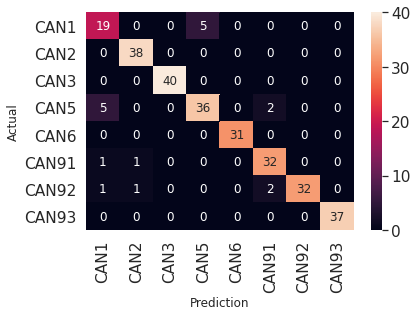


[[19  0  0  5  0  0  0  0]
 [ 0 38  0  0  0  0  0  0]
 [ 0  0 40  0  0  0  0  0]
 [ 5  0  0 36  0  2  0  0]
 [ 0  0  0  0 31  0  0  0]
 [ 1  1  0  0  0 32  0  0]
 [ 1  1  0  0  0  2 32  0]
 [ 0  0  0  0  0  0  0 37]]


In [ ]:
### VI. Produce Confusion Matrix ###
print('\n--- Confusion Matrix ---\n')

cm = sm.confusion_matrix(Y_test, Y_pred)
tr = cm.size       # Total Records
np.sum(cm, axis=0) # Column Sum     (Horizontal Result)
np.sum(cm, axis=1) # Row Sum        (Vertical Result)
np.trace(cm)       # Diagonal Sum   (Total Result)

df_cm = pd.DataFrame(cm, y.unique(), y.unique())
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}) # font size
plt.xlabel("Prediction", fontsize = 12)
plt.ylabel("Actual", fontsize = 12)

plt.show()

print('')
print(cm)

# VII. Evaluate Peformance Metrics


--- Performance Metrics ---

[ ECU_Id | Accuracy | Precision | Recall | F1 Score | Error ]
=========|==========|===========|========|==========|========
[   CAN1 |    0.958 |     0.731 |  0.792 |    0.760 | 0.042 ]
[   CAN2 |    0.993 |     0.950 |  1.000 |    0.974 | 0.007 ]
[   CAN3 |    1.000 |     1.000 |  1.000 |    1.000 | 0.000 ]
[   CAN5 |    0.958 |     0.878 |  0.837 |    0.857 | 0.042 ]
[   CAN6 |    1.000 |     1.000 |  1.000 |    1.000 | 0.000 ]
[  CAN91 |    0.979 |     0.889 |  0.941 |    0.914 | 0.021 ]
[  CAN92 |    0.986 |     1.000 |  0.889 |    0.941 | 0.014 ]
[  CAN93 |    1.000 |     1.000 |  1.000 |    1.000 | 0.000 ]



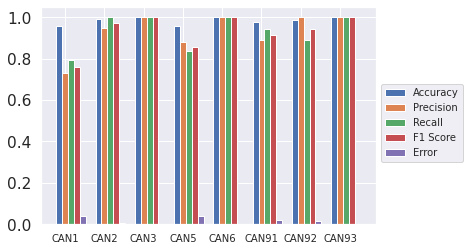

In [ ]:
### VII. Evaluate Performance Metrics ###
print('\n--- Performance Metrics ---\n')

def perf_metrics(cm, report=False):

  cm_acc = []
  cm_pre = []
  cm_rec = []
  cm_f1s = []
  cm_err = []

  if report:
    print('[ ECU_Id | Accuracy | Precision | Recall | F1 Score | Error ]')
    print('=========|==========|===========|========|==========|========')

  for i in np.arange(len(cm)):
    cm_working = cm.copy()
    idx = np.concatenate((np.arange(0,i),np.arange(-len(cm)+i+1,0)))

    tp = cm_working[i,i]
    fn = cm_working[i,idx]; fn = np.sum(fn)
    fp = cm_working[idx,i]; fp = np.sum(fp)

    cm_working[i,i] = 0
    cm_working[i,idx] = 0
    cm_working[idx,i] = 0

    tn = np.sum(cm_working)

    acc = (tp + tn)/(tp + tn + fp + fn)
    err = 1-acc
    pre = tp/(tp + fp)
    rec = tp/(tp + fn)
    f1s = 2*(pre*rec)/(pre+rec)

    cm_acc.append(acc)
    cm_pre.append(pre)
    cm_rec.append(rec)
    cm_f1s.append(f1s)
    cm_err.append(err)

    if report:
      print('[%7s | %8.3f | %9.3f | %6.3f | %8.3f | %5.3f ]' \
            % (y.unique()[i], acc, pre, rec, f1s, err))

  return cm_acc, cm_pre, cm_rec, cm_f1s, cm_err

acc, pre, rec, f1s, err = perf_metrics(cm, True)

# Plot results

bw = 0.15   # Box plot bar width

p1 = np.arange(len(acc))    # Category x-axis positions
p2 = [x + bw for x in p1]
p3 = [x + bw for x in p2]
p4 = [x + bw for x in p3]
p5 = [x + bw for x in p4]

print('') 
plt.bar(p1, acc, width=bw)
plt.bar(p2, pre, width=bw)
plt.bar(p3, rec, width=bw)
plt.bar(p4, f1s, width=bw)
plt.bar(p5, err, width=bw)
 
plt.xticks([p + bw for p in range(len(acc))], y.unique(), fontsize = 10)
plt.legend(['Accuracy','Precision','Recall','F1 Score','Error'], fontsize = 10, bbox_to_anchor = (1, 0.67))

# Appendix I. Neural Network Hyperparameter Testing


--- Training and Test Datasets ---

Training Input:

    float64: (660, 35)

Training Output:

    int64: (660,)

Test Input:

    float64: (283, 35)

Test Output:

    int64: (283,)

--- Neural Network Training ---

Hidden Layer Nodes:     500
Neural Network Solver:  adam

--- Confusion Matrix ---



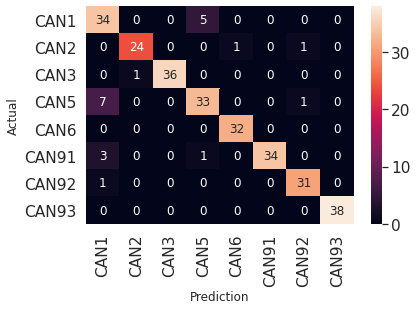


[[34  0  0  5  0  0  0  0]
 [ 0 24  0  0  1  0  1  0]
 [ 0  1 36  0  0  0  0  0]
 [ 7  0  0 33  0  0  1  0]
 [ 0  0  0  0 32  0  0  0]
 [ 3  0  0  1  0 34  0  0]
 [ 1  0  0  0  0  0 31  0]
 [ 0  0  0  0  0  0  0 38]]

--- Performance Metrics ---

[ ECU_Id | Accuracy | Precision | Recall | F1 Score | Error ]
=========|==========|===========|========|==========|========
[   CAN1 |    0.943 |     0.756 |  0.872 |    0.810 | 0.057 ]
[   CAN2 |    0.989 |     0.960 |  0.923 |    0.941 | 0.011 ]
[   CAN3 |    0.996 |     1.000 |  0.973 |    0.986 | 0.004 ]
[   CAN5 |    0.951 |     0.846 |  0.805 |    0.825 | 0.049 ]
[   CAN6 |    0.996 |     0.970 |  1.000 |    0.985 | 0.004 ]
[  CAN91 |    0.986 |     1.000 |  0.895 |    0.944 | 0.014 ]
[  CAN92 |    0.989 |     0.939 |  0.969 |    0.954 | 0.011 ]
[  CAN93 |    1.000 |     1.000 |  1.000 |    1.000 | 0.000 ]

98.14 93.39 92.95 93.06 1.86


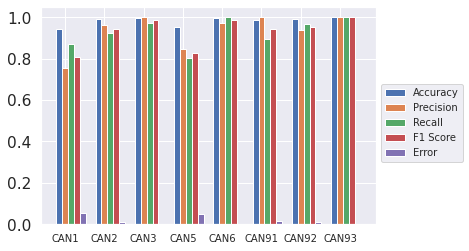

In [ ]:
### IV. Prepare Training and Test Datasets ###
print('\n--- Training and Test Datasets ---\n')

# Attribute and Label Datasets

## Full, Spectral, Contrl, Dom, Rec                                                                     Acc %
X = df.iloc[:,5:]                                                               # Full feature set    98.76%
# X = df.iloc[:,[12,13,14,15,16,17,18,19,20,21,22,23,24,32,33,34,35,36,37,38,39]] # Spectral Only       97.26%
# X = df.iloc[:,[5,6,7,8,9,10,11,25,26,27,28,29,30,31]]                           # Control Only        97.17%
# X = df.iloc[:, 5:24]                                                            # Dominant Only       98.14%
# X = df.iloc[:,25:39]                                                            # Recessive Only      96.73%

## Spectral Features (sorted by Accuracy)
# X = df.iloc[:,[22,37]]                                                          # SNR                 95.23%
# X = df.iloc[:,[23,38]]                                                          # Mean Freq           94.96%
# X = df.iloc[:,[12,13,14,15,16,17,18,19,20,21,32,33,34,35,36]]                   # Spectral Density    92.93%
# X = df.iloc[:,[24,39]]                                                          # Median Freq         91.34%

## Spectral Features (added by rank)
# X = df.iloc[:,[22,37]]                                                          # SNR                 95.23% [ ]
# X = df.iloc[:,[22,23,37,38]]                                                    #  + Mean Freq        97.35% [+] <<<
# X = df.iloc[:,[12,13,14,15,16,17,18,19,20,21,22,23,32,33,34,35,36,37,38]]       #  + Spectral Density 97.26% [-]
# X = df.iloc[:,[12,13,14,15,16,17,18,19,20,21,22,23,32,33,34,35,36,37,38]]       #  + Median Freq      97.26% [-]

## Control Features (sorted by Accuracy)
# X = df.iloc[:,[ 8,28]]                                                          # Steady State Value  95.23%
# X = df.iloc[:,[ 9,29]]                                                          # Steady State Error  95.05%
# X = df.iloc[:,[ 6,26]]                                                          # Percent Overshoot   91.52%
# X = df.iloc[:,[ 7,27]]                                                          # Settling Time       91.52%
# X = df.iloc[:,[10,30]]                                                          # Rise Time           83.48%
# X = df.iloc[:,[11,31]]                                                          # Delay Time          81.89%
# X = df.iloc[:,[ 5,25]]                                                          # Peak Time           80.12%

## Control Features (added by rank)
# X = df.iloc[:,[8,28]]                                                           # SSV                 95.23% [ ]
# X = df.iloc[:,[8,9,28,29]]                                                      #  + SSE              97.70% [+]
# X = df.iloc[:,[6,8,9,26,28,29]]                                                 #  + %OS              98.32% [+] <<<
# X = df.iloc[:,[6,7,8,9,26,27,28,29]]                                            #  + Ts               98.32% [=]
# X = df.iloc[:,[6,7,8,9,10,26,27,28,29,30]]                                      #  + Tr               97.26  [-]
# X = df.iloc[:,[6,7,8,9,10,11,26,27,28,29,30,31]]                                #  + Td               97.17% [-]
# X = df.iloc[:,[ 5,25]]                                                          #  + Tp               97.17% [=]

## All Features (added by rank)
# X = df.iloc[:,[22,37]]                                                                   # SNR                95.23% [ ]
# X = df.iloc[:,[8,22,28,37]]                                                              #  + SSV             97.53% [+]
# X = df.iloc[:,[8,9,22,28,29,37]]                                                         #  + SSE             97.97% [+]
# X = df.iloc[:,[8,9,22,23,28,29,37,38]]                                                   #  + Mean Freq.      98.59% [+]
# X = df.iloc[:,[6,8,9,22,23,26,28,29,37,38]]                                              #  + %OS             98.94% [+] <<<
# X = df.iloc[:,[6,7,8,9,22,23,26,27,28,29,37,38]]                                         #  + Ts              98.85% [-]
# X = df.iloc[:,[6,7,8,9,22,23,24,26,27,28,29,37,38,39]]                                   #  + Med. Freq.      98.67% [-]
# X = df.iloc[:,[6,8,9,12,13,14,15,16,17,18,19,20,21,22,23,26,28,29,32,33,34,35,36,37,38]] #  + SD              98.32% [-]
# X = df.iloc[:,[10,30]]                                                                   #  + Tr              ...
# X = df.iloc[:,[11,31]]                                                                   #  + Td              ...
# X = df.iloc[:,[ 5,25]]                                                                   #  + Tp              ...

## Final Feature Set: (Control) SSV, SSE, %OS (Spectral) SNR, Mean Freq.
# X = df.iloc[:,[6,8,9,22,23,26,28,29,37,38]]                                     # 99.12%

# Testing Results
y = df.iloc[:,1]

# Change Labels from Categorical to Numerical values
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
Y = le.fit_transform(y)

# Train-Test Split (70/30)
from sklearn.model_selection import train_test_split
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)    # Apples to Apples Debugging
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

# Print Training/Test Set Details
print('Training Input:\n')
print('    %s: %s' %(X_train.dtype, X_train.shape))
print('\nTraining Output:\n')
print('    %s: %s' %(Y_train.dtype, Y_train.shape))
print('\nTest Input:\n')
print('    %s: %s' %(X_test.dtype, X_test.shape))
print('\nTest Output:\n')
print('    %s: %s' %(Y_test.dtype, Y_test.shape))

### V. Train Neural Network ###
print('\n--- Neural Network Training ---\n')

from sklearn.neural_network import MLPClassifier

# hls = np.round(3*len(df)).astype(int)
hls = 500
mit = 3000

mlp = MLPClassifier(hidden_layer_sizes=([hls,]),   max_iter=mit)
mlp.fit(X_train, Y_train.ravel())
Y_pred = mlp.predict(X_test)
print('Hidden Layer Nodes:    ',len(mlp.coefs_[1]))
print('Neural Network Solver: ',mlp.solver)

### VI. Produce Confusion Matrix ###
print('\n--- Confusion Matrix ---\n')

cm = sm.confusion_matrix(Y_test, Y_pred)
tr = cm.size       # Total Records
np.sum(cm, axis=0) # Column Sum     (Horizontal Result)
np.sum(cm, axis=1) # Row Sum        (Vertical Result)
np.trace(cm)       # Diagonal Sum   (Total Result)

df_cm = pd.DataFrame(cm, y.unique(), y.unique())
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}) # font size
plt.xlabel("Prediction", fontsize = 12)
plt.ylabel("Actual", fontsize = 12)

plt.show()

print('')
print(cm)

### VII. Evaluate Performance Metrics ###
print('\n--- Performance Metrics ---\n')

def perf_metrics(cm, report=False):

  cm_acc = []
  cm_pre = []
  cm_rec = []
  cm_f1s = []
  cm_err = []

  if report:
    print('[ ECU_Id | Accuracy | Precision | Recall | F1 Score | Error ]')
    print('=========|==========|===========|========|==========|========')

  for i in np.arange(len(cm)):
    cm_working = cm.copy()
    idx = np.concatenate((np.arange(0,i),np.arange(-len(cm)+i+1,0)))

    tp = cm_working[i,i]
    fn = cm_working[i,idx]; fn = np.sum(fn)
    fp = cm_working[idx,i]; fp = np.sum(fp)

    cm_working[i,i] = 0
    cm_working[i,idx] = 0
    cm_working[idx,i] = 0

    tn = np.sum(cm_working)

    acc = (tp + tn)/(tp + tn + fp + fn)
    err = 1-acc
    pre = tp/(tp + fp)
    rec = tp/(tp + fn)
    f1s = 2*(pre*rec)/(pre+rec)

    cm_acc.append(acc)
    cm_pre.append(pre)
    cm_rec.append(rec)
    cm_f1s.append(f1s)
    cm_err.append(err)

    if report:
      print('[%7s | %8.3f | %9.3f | %6.3f | %8.3f | %5.3f ]' \
            % (y.unique()[i], acc, pre, rec, f1s, err))

  return cm_acc, cm_pre, cm_rec, cm_f1s, cm_err

acc, pre, rec, f1s, err = perf_metrics(cm, True)

# Plot results

bw = 0.15   # Box plot bar width

p1 = np.arange(len(acc))    # Category x-axis positions
p2 = [x + bw for x in p1]
p3 = [x + bw for x in p2]
p4 = [x + bw for x in p3]
p5 = [x + bw for x in p4]

print('') 
plt.bar(p1, acc, width=bw)
plt.bar(p2, pre, width=bw)
plt.bar(p3, rec, width=bw)
plt.bar(p4, f1s, width=bw)
plt.bar(p5, err, width=bw)
 
plt.xticks([p + bw for p in range(len(acc))], y.unique(), fontsize = 10)
plt.legend(['Accuracy','Precision','Recall','F1 Score','Error'], fontsize = 10, bbox_to_anchor = (1, 0.67))

acc_avg = np.average(acc)*100
pre_avg = np.average(pre)*100
rec_avg = np.average(rec)*100
f1s_avg = np.average(f1s)*100
err_avg = np.average(err)*100

print('%2.2f %2.2f %2.2f %2.2f %2.2f' % (acc_avg, pre_avg, rec_avg, f1s_avg, err_avg))

([<matplotlib.axis.XTick at 0x7f6031bfb0d0>,
 [Text(0, 0, '98.76'),
  Text(0, 0, '95.06'),
  Text(0, 0, '95.1'),
  Text(0, 0, '95.01'),
  Text(0, 0, '1.24')])

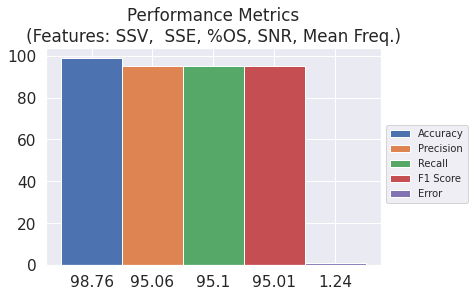

In [ ]:
# Plot results (using custom statistics)

bw = 0.15   # Box plot bar width

p1 = 0
p2 = p1 + bw
p3 = p2 + bw
p4 = p3 + bw
p5 = p4 + bw

# Optimal Method 2 Featureset

acc = 98.76
pre = 95.06
rec = 95.10
f1s = 95.01
err = 1.24

fig, ax = plt.subplots()
# ax.set_facecolor("white")
plt.bar(p1, acc, width=bw)
plt.bar(p2, pre, width=bw)
plt.bar(p3, rec, width=bw)
plt.bar(p4, f1s, width=bw)
plt.bar(p5, err, width=bw)

plt.title('Performance Metrics\n(Features: SSV,  SSE, %OS, SNR, Mean Freq.)') 
plt.legend(['Accuracy','Precision','Recall','F1 Score','Error'], fontsize = 10, bbox_to_anchor = (1, 0.67))
# plt.grid(False)

plt.xticks([p1,p2,p3,p4,p5], [acc,pre,rec,f1s,err])

([<matplotlib.axis.XTick at 0x7f6031d35a50>,
 [Text(0, 0, '98.28'),
  Text(0, 0, '93.22'),
  Text(0, 0, '93.17'),
  Text(0, 0, '93.07'),
  Text(0, 0, '1.72')])

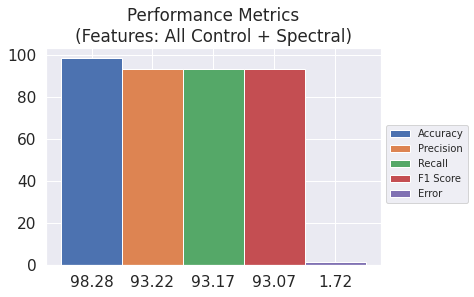

In [ ]:
# Full Method 2 Featureset

acc = 98.28
pre = 93.22
rec = 93.17
f1s = 93.07
err = 1.72

print('') 
plt.bar(p1, acc, width=bw)
plt.bar(p2, pre, width=bw)
plt.bar(p3, rec, width=bw)
plt.bar(p4, f1s, width=bw)
plt.bar(p5, err, width=bw)

plt.title('Performance Metrics\n(Features: All Control + Spectral)') 
plt.legend(['Accuracy','Precision','Recall','F1 Score','Error'], fontsize = 10, bbox_to_anchor = (1, 0.67))
plt.xticks([p1,p2,p3,p4,p5], [acc,pre,rec,f1s,err])

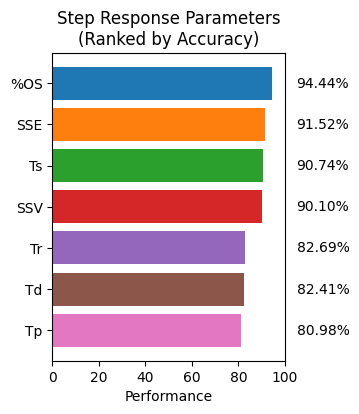

In [ ]:
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(3, 4))

# Example data
labels = ('%OS', 'SSE', 'Ts' , 'SSV', 'Tr' , 'Td' , 'Tp')
y_pos = np.arange(len(labels))
avg = [94.44, 91.52, 90.74, 90.10, 82.69, 82.41, 80.98]

for i in np.arange(len(y_pos)):
  ax.barh(y_pos[i], avg[i])
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Performance')
ax.set_title('Step Response Parameters\n(Ranked by Accuracy)')
for index, value in enumerate(avg):
    plt.text(105, index+0.1,
             '%2.2f%%' % value)
plt.xlim((0,100))

plt.show()